In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

from utils import plot_images

In [2]:
DATA_DIR = '/data/spacenet6'

In [3]:
import json

In [4]:
def get_data_list(json_path):
    with open(json_path) as f:
        data_list = json.load(f)
    return data_list

train_list = get_data_list(os.path.join(DATA_DIR, 'split/train_0.json'))
val_list = get_data_list(os.path.join(DATA_DIR, 'split/val_0.json'))

In [5]:
image_dir = os.path.join(DATA_DIR, 'spacenet6/train/SAR-Intensity')
mask_dir = os.path.join(DATA_DIR, 'footprint_boundary_mask/v_01/labels')

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

from skimage import io

In [8]:
class Dataset(BaseDataset):
    CLASSES = ['background', 'building_footprint', 'building_boundary']
    
    def __init__(
        self,
        data_list,
        image_dir,
        mask_dir,
        classes=None,
        augmentation=None, 
        preprocessing=None
    ):
        
        # generate full path to image/mask file
        self.image_paths, self.mask_paths = [], []
        for data in data_list:
            self.image_paths.append(os.path.join(image_dir, data['SAR-Intensity']))
            self.mask_paths.append(os.path.join(mask_dir, data['Mask']))
        
        # convert str names to class values on masks
        if not classes:
            classes = self.CLASSES
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        image = io.imread(self.image_paths[i])
        mask = io.imread(self.mask_paths[i])

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
                             
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
    
    def __len__(self):
        return len(self.image_paths)
    
    def mask_channel_of(self, class_name):
        assert class_name in self.CLASSES
        return self.class_values.index(self.CLASSES.index(class_name))

In [9]:
train_dataset = Dataset(train_list, image_dir, mask_dir, classes=['building_footprint', 'building_boundary'])
val_dataset = Dataset(val_list, image_dir, mask_dir, classes=['building_footprint', 'building_boundary'])

channel_footprint = train_dataset.mask_channel_of('building_footprint')
channel_boundary = train_dataset.mask_channel_of('building_boundary')

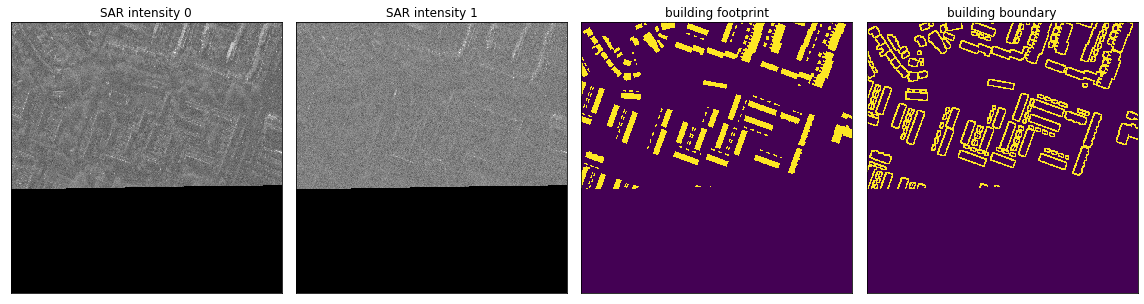

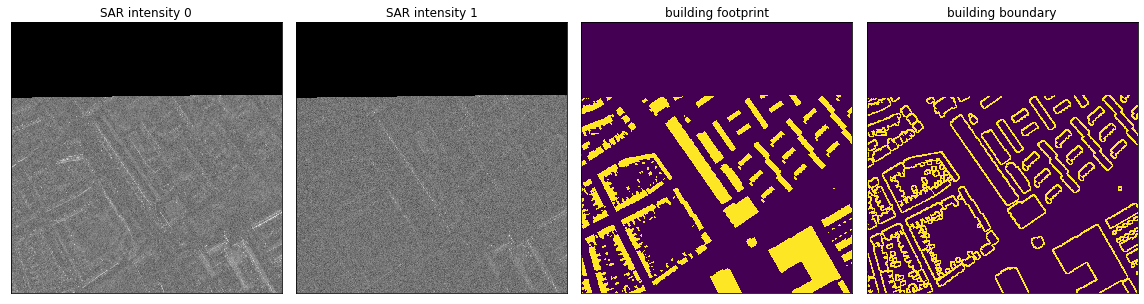

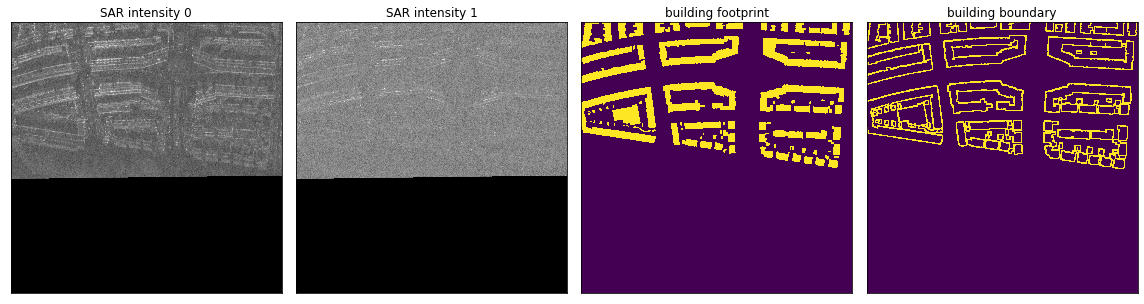

In [10]:
for i in [100, 500, 2000]:
    image, mask = train_dataset.__getitem__(i)

    plot_images(
        SAR_intensity_0=(image[:, :, 0], 'gray'),
        SAR_intensity_1=(image[:, :, 1], 'gray'),
        building_footprint=(mask[:, :, channel_footprint], 'viridis'),
        building_boundary=(mask[:, :, channel_boundary], 'viridis')
    )

In [11]:
# load pre-computed meam and std
mean_path = os.path.join(DATA_DIR, 'image_mean_std/SAR-Intensity/mean.npy')
mean = np.load(mean_path)
print(f'mean: {mean}')

std_path = os.path.join(DATA_DIR, 'image_mean_std/SAR-Intensity/std.npy')
std = np.load(std_path)
print(f'std: {std}')

mean: [19.25729654 24.23937074 22.72454719 17.63656102]
std: [15.16594333 18.27533709 17.30870347 14.25647672]


In [12]:
import albumentations as albu

In [13]:
def get_training_augmentation():
    train_transform = [
        # random flip
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        # random rotate
        albu.ShiftScaleRotate(scale_limit=0.0, rotate_limit=(-45, 45), shift_limit=0.0, p=1, border_mode=0),
        # random crop
        albu.RandomCrop(height=864, width=864, always_apply=True),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(min_height=928, min_width=928, always_apply=True, border_mode=0),
    ]
    return albu.Compose(test_transform)


def normalize_image(x, **kwargs):
    x -= mean[np.newaxis, np.newaxis, :]
    x /= std[np.newaxis, np.newaxis, :]
    return x


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing():
    """Construct preprocessing transform
    Return:
        transform: albumentations.Compose
    
    """
    import functools
    
    _transform = [
        albu.Lambda(image=functools.partial(normalize_image)),
        albu.Lambda(image=functools.partial(to_tensor), mask=functools.partial(to_tensor)),
    ]
    return albu.Compose(_transform)

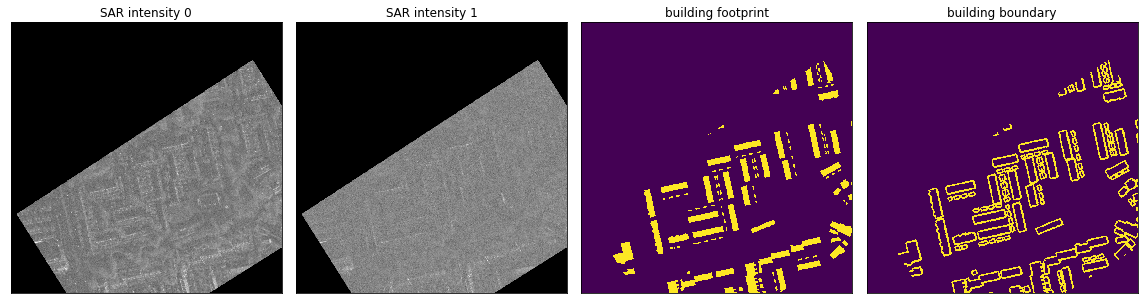

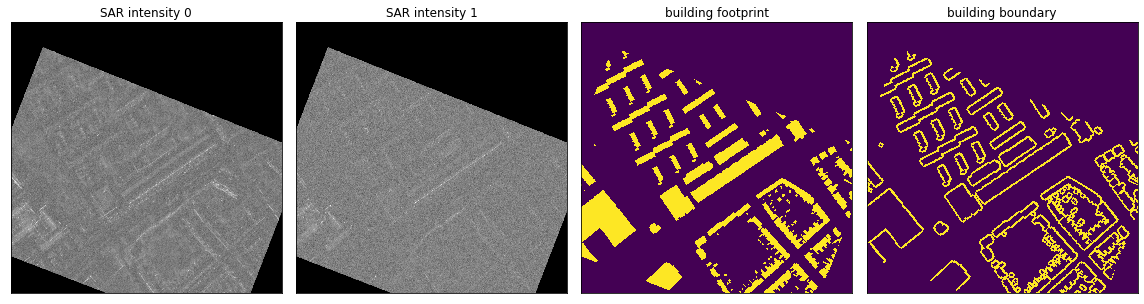

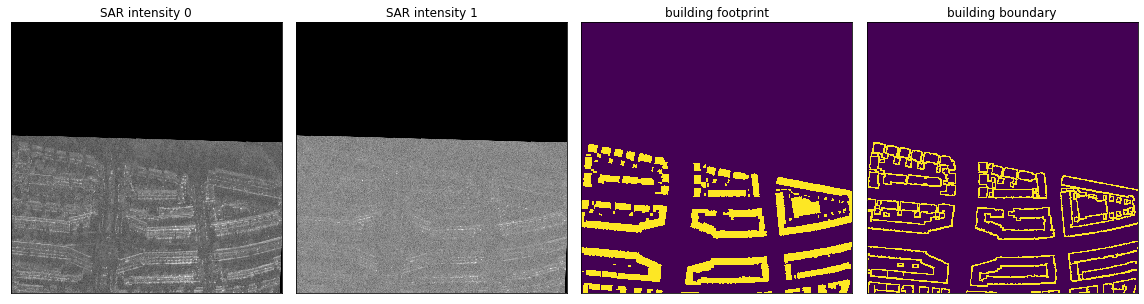

In [14]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    train_list,
    image_dir,
    mask_dir,
    classes=['building_footprint', 'building_boundary'],
    augmentation=get_training_augmentation()
)

for i in [100, 500, 2000]:
    image, mask = augmented_dataset.__getitem__(i)

    plot_images(
        SAR_intensity_0=(image[:, :, 0], 'gray'),
        SAR_intensity_1=(image[:, :, 1], 'gray'),
        building_footprint=(mask[:, :, channel_footprint], 'viridis'),
        building_boundary=(mask[:, :, channel_boundary], 'viridis')
    )

In [15]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [16]:
ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['building_footprint', 'building_boundary']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
    in_channels=4
)

Downloading: "https://publicmodels.blob.core.windows.net/container/aa/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/checkpoints/efficientnet-b3-5fb5a3c3.pth


In [17]:
train_dataset = Dataset(
    train_list,
    image_dir,
    mask_dir,
    classes=CLASSES,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing()
)

val_dataset = Dataset(
    val_list,
    image_dir,
    mask_dir,
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing()
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=12)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [18]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=1e-4),
])

In [19]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

val_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [20]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    val_logs = val_epoch.run(val_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < val_logs['iou_score']:
        max_score = val_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 681/681 [01:36<00:00,  7.05it/s, dice_loss - 0.7081, iou_score - 0.2073]
Model saved!

Epoch: 1
valid: 100%|██████████| 681/681 [01:35<00:00,  7.10it/s, dice_loss - 0.6636, iou_score - 0.2782]
Model saved!

Epoch: 2
valid: 100%|██████████| 681/681 [01:35<00:00,  7.15it/s, dice_loss - 0.6957, iou_score - 0.2689]

Epoch: 3
valid: 100%|██████████| 681/681 [01:35<00:00,  7.15it/s, dice_loss - 0.6156, iou_score - 0.3176]
Model saved!

Epoch: 4
valid: 100%|██████████| 681/681 [01:35<00:00,  7.12it/s, dice_loss - 0.6125, iou_score - 0.3288]
Model saved!

Epoch: 5
valid: 100%|██████████| 681/681 [01:36<00:00,  7.04it/s, dice_loss - 0.5615, iou_score - 0.3534]
Model saved!

Epoch: 6
valid: 100%|██████████| 681/681 [01:34<00:00,  7.18it/s, dice_loss - 0.5678, iou_score - 0.3441]

Epoch: 7
valid: 100%|██████████| 681/681 [01:34<00:00,  7.17it/s, dice_loss - 0.5475, iou_score - 0.353] 

Epoch: 8
valid: 100%|██████████| 681/681 [01:35<00:00,  7.09it/s, dice_loss - 